## reverse image search and retrieval

This notebook will show you how you can use a convolutional neural network (convnet) to search through a large collection of images. Specifically, it will show you how you can retrieve a set of images which are similar to a query image, returning you its `n` nearest neighbors in terms of image content.

For more information about how convnets analyze images, read the [ml4a chapter on convnets](http://ml4a.github.io/ml4a/convnets/). 

A [second notebook](image-tsne.ipynb) will show you how you a related technique in which you can visualize your image collection with [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). 

### Installation and dependencies

The code has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [numpy](http://www.numpy.org/)
 * [scipy](http://scipy.org)
 * [matplotlib](http://matplotlib.org)
 * [scikit-learn](scikit-learn.org)
 * [keras](https://keras.io)
 * [h5py](http://www.h5py.org/)
 * [Pillow](https://python-pillow.org/)

You should also download the weights of the VGG-16 network. You can download the file `vgg16_weights.h5` [here](https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing).

### Prepare dataset

Finally prepare a folder of images to do the t-SNE on. If you don't have one, you may download and extract the [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) containing roughly 9000 images in 101 categories. To download that dataset, run the following commands inside a folder of your choosing (this notebook will assume you do so in the `data` folder of `ml4a-guides`.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [211]:
%matplotlib inline
import os
import random
import numpy as np
import h5py
from matplotlib.pyplot import imshow
import matplotlib.pyplot
from PIL import Image
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import TSNE

Now let's set the paths to all our files. Make sure `vgg_path` points to your `vgg16_weights.h5` file and images_path points to the folder of images you wish to analyze.

The `num_images` variable sets how many images we wish to compute the t-SNE for. This shouldn't be higher than the number of images you have. 

In [157]:
vgg_path = '../data/vgg16_weights.h5'
images_path = '../data/101_ObjectCategories'
num_images = 5000

We will define two functions which we will need later. 

The function `get_impage(path)` will grab an image and convert it into a numpy array of the correct size for further processing. 

The function `VGG_16(weights_path)` will define the VGG16 neural net architecture and load the weights into it from the h5 file you downloaded earlier.

In [158]:
def get_image(path):
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224), Image.ANTIALIAS)  # resize the image to fit into VGG-16
    img = np.array(img.getdata(), np.uint8)
    img = img.reshape(224, 224, 3).astype(np.float32)
    img[:,:,0] -= 123.68 # subtract mean (probably unnecessary for t-SNE but good practice)
    img[:,:,1] -= 116.779
    img[:,:,2] -= 103.939
    img = img.transpose((2,0,1))
    img = np.expand_dims(img, axis=0)
    return img

def VGG_16(weights_path):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    print("finished loading VGGNet")
    return model

Next, we will go ahead and load the VGG16 network and its saved weights, as well as compile it with an associated solver function (`SGD`) although in this example we won't actually use the `SGD` for anything.

In [159]:
model = VGG_16(vgg_path)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

finished loading VGGNet


Next, we will load all the paths to our images into an array `images`, recursively from `image_path`.  If `num_images` < the number of images you have, it will filter out a random subsample of `num_images` images.

In [160]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), num_images))]

print("keeping %d images to analyze" % len(images))

keeping 5000 images to analyze


Now we will go through every image, and extract its activations. The activations we are interested in are those in the last fully-connected layer of a convnet that we forward pass the image through.

In [161]:
activations = []
for idx,image_path in enumerate(images):
    print "getting activations for %d/%d %s" % (idx+1, len(images), image_path)
    image = get_image(image_path);
    acts = model.predict(image)[0]
    activations.append(acts)


getting activations for 0/5000 ../data/101_ObjectCategories/accordion/image_0003.jpg
getting activations for 1/5000 ../data/101_ObjectCategories/accordion/image_0006.jpg
getting activations for 2/5000 ../data/101_ObjectCategories/accordion/image_0007.jpg
getting activations for 3/5000 ../data/101_ObjectCategories/accordion/image_0009.jpg
getting activations for 4/5000 ../data/101_ObjectCategories/accordion/image_0010.jpg
getting activations for 5/5000 ../data/101_ObjectCategories/accordion/image_0011.jpg
getting activations for 6/5000 ../data/101_ObjectCategories/accordion/image_0012.jpg
getting activations for 7/5000 ../data/101_ObjectCategories/accordion/image_0013.jpg
getting activations for 8/5000 ../data/101_ObjectCategories/accordion/image_0014.jpg
getting activations for 9/5000 ../data/101_ObjectCategories/accordion/image_0016.jpg
getting activations for 10/5000 ../data/101_ObjectCategories/accordion/image_0020.jpg
getting activations for 11/5000 ../data/101_ObjectCategories/acc

Each set of activations is a 4096-element list which provides a high-level characterization of that image. Some of the elements may be interpratable, corresponding to real-world objects, while others are more abstract. 

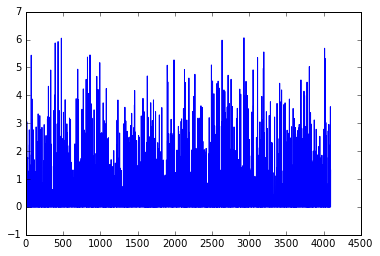

In [212]:
matplotlib.pyplot.plot(np.array(activations[0]))
matplotlib.pyplot.show()

Now that we have all the activations, we're going to reduce their dimensionality from 4096 down to 300 using [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), a dimensionality reduction technique which transforms high-dimensional data into a lower-dimensional subspace. PCA is not totally necessary for this application, as we can use the full feature vector and get acceptable results. However in practice PCA improves our representation by removing redundant information in the activations.

In [ ]:
acts = np.array(activations)
pca = PCA(n_components=300)
pca.fit(acts)
acts = pca.transform(acts)

The variable `acts` now contains our PCA-transformed activation vectors, and we will now use those for doing our image searches.  

Let's do a query. What we'll do is define a function which returns the `num_results` closest images to a query image, with repsect to those images contents. What it dos is: for the given query image, it will take its PCA-activations, and compute the euclidean distance between it and every other set of PCA-activations, then return the best ones.

We also define a helper function `get_concatenated_images` which creates a thumbnail of a set of images, so we can display the results.

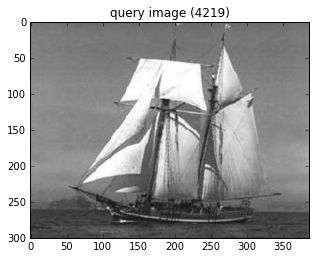

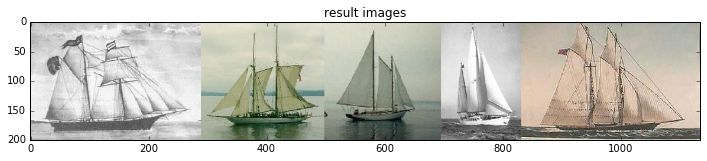

In [242]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = Image.open(images[idx])
        img = img.resize((img.width * thumb_height / img.height, thumb_height), Image.ANTIALIAS)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

def get_closest_images(query_image_idx, num_results=5):
    thumb_height = 200
    distances = [ distance.euclidean(acts[query_image_idx], act) for act in acts ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest
    

# let's do a query    
query_image_idx = int(num_images*random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)
matplotlib.pyplot.figure(figsize = (12,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

Let's try another one.

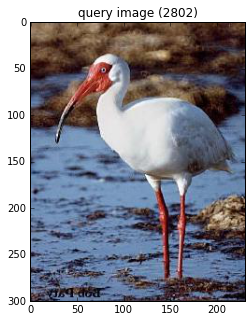

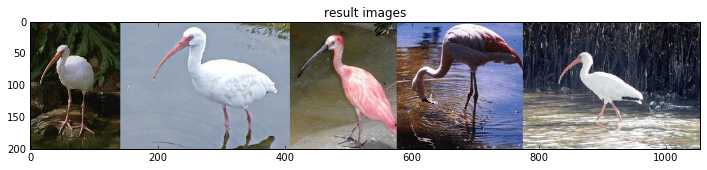

In [251]:
query_image_idx = int(num_images*random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)
matplotlib.pyplot.figure(figsize = (12,12))
imshow(results_image)
matplotlib.pyplot.title("result images")